In [1]:
import numpy as np
import pandas as pd
import keras
import shutil
import tensorflow as tf

import seaborn as sns

from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

2024-02-16 22:39:26.217610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 22:39:26.217725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 22:39:26.347793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ELEC0135 Assignment

## Introduction

Based on the competition here: https://www.kaggle.com/competitions/cassava-leaf-disease-classification

## Source Data

As this is an exploratory Kaggle notebook, I've just loaded in the hosted `cassava-leaf-diesease-classification` dataset in here.  The final script will need some data loading logic, so that it can be submitted for testing/marking purposes.

In [2]:
SOURCE_DATA = Path("/kaggle/input/cassava-leaf-disease-classification/")

WORKING_DATA = Path("/kaggle/working/data/elec0135-assignment-cld/")
WORKING_DATA.mkdir(parents=True, exist_ok=True)

# Parameters
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.25
EPOCHS = 50

## EDA

### Class Balance

There's a large class imbalance here, which will need taking into account during the training.  Initial thoughts are that this will be especially true if I end up using a binary-classification gate in a `Mixture of Experts` model.

In [3]:
df_train = pd.read_csv(SOURCE_DATA / "train.csv")
df_train.groupby(['label']).count()

,image_id
label,
0,1087
1,2189
2,2386
3,13158
4,2577


## Data Processing

With only ~1000 instances of label/class `0`, my first thought is that some data augmentation is going to be required here.  I'm going to hold off with that first and see how a basic VGG-style network, such as that explored in the labs, fares.


In [4]:
def create_equal_split_dataset(df_map: pd.DataFrame) -> Path:
    es_path = WORKING_DATA / "equal_split"
    es_path.mkdir(parents=True, exist_ok=True)
    
    for lab in df_map.label.unique():
        (es_path / str(lab)).mkdir(exist_ok=True)
        
    source_path = SOURCE_DATA / "train_images"
    
    # take n first items from each class
    df_map['counter'] = 1
    df_map['class_count'] = df_map[['label', 'counter']].groupby(['label']).cumsum()
    
    for index, row in df_map.iterrows():
        lab = row["label"]
        image_id = row["image_id"]
        img = source_path / image_id
        dest = es_path / str(lab) / image_id

        class_count = row["class_count"]
        if class_count > 1087:
            continue
        shutil.copyfile(img, dest)
        
    return es_path


def get_equal_split_dataset(path: Path):
    # Load dataset
    # categorical here means that the labels are one-hot encoded
    ds_train_, ds_valid_ = image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[120, 160],
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_split=VALIDATION_SPLIT,
        subset="both",
        seed=31415,
    )   

    # Data Pipeline
    def convert_to_float(image, label):
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds_train = (
        ds_train_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_valid = (
        ds_valid_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    return ds_train, ds_valid


def plot_experiment_results(df_history: pd.DataFrame, exp_id: str) -> None:
    df = df_history[df_history.exp_id == exp_id]
    df[['loss', 'val_loss']].plot()
    df[['accuracy', 'val_accuracy']].plot();

In [5]:
# need to add some optimisation here to avoid re-create files if already exist
dataset_path = create_equal_split_dataset(df_train)

ds_train, ds_valid = get_equal_split_dataset(dataset_path)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.


### Model

In [6]:
# df_experiment = pd.DataFrame(columns=["exp_id", "desc", "batch_size", "img_width", "img_height", "model"])
# df_history = pd.DataFrame(columns=["loss", "accuracy", "val_loss", "val_accuracy"])

In [7]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model() -> Model:
    return keras.Sequential([

        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                      # give the input dimensions in the first layer
                      # [height, width, color channels(RGB)]
                      input_shape=[120, 160, 3]),
        layers.BatchNormalization(renorm=True),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(units=5, activation="softmax"),
    ])

In [8]:
# similar to above, but with batchnormalisation added
def create_simple_model_bn() -> Model:
    return keras.Sequential([

        # First Convolutional Block ([height, width, color channels(RGB)])
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                      input_shape=[120, 160, 3]),
        layers.BatchNormalization(renorm=True),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(units=5, activation="softmax"),
    ])

In [9]:
def run_experiment(exp_id: str, model_fn: str, ds_train_, ds_valid_):
    
    #data = {"exp_id":"1", "desc":"something", "batch_size":BATCH_SIZE, "img_width":0, "img_height":0, "model": model_str}
    #df_experiment = pd.concat([pd.DataFrame([data]), df_experiment])
    
    model = model_fn()
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=10,
        restore_best_weights=True,
    )

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[early_stopping],
    )
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist

In [10]:
(m, df_hist) = run_experiment("1", create_simple_model, ds_train, ds_valid)

Epoch 1/50


2024-02-16 22:40:43.170714: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708123248.192523      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - 24s 179ms/step - loss: 2.3098 - accuracy: 0.2065 - val_loss: 1.6087 - val_accuracy: 0.2290
Epoch 2/50
64/64 [==============================] - 7s 108ms/step - loss: 1.6092 - accuracy: 0.1908 - val_loss: 1.6090 - val_accuracy: 0.1922
Epoch 3/50
64/64 [==============================] - 7s 109ms/step - loss: 1.6082 - accuracy: 0.2144 - val_loss: 1.6070 - val_accuracy: 0.2084
Epoch 4/50
64/64 [==============================] - 7s 108ms/step - loss: 1.5900 - accuracy: 0.2487 - val_loss: 1.5842 - val_accuracy: 0.2916
Epoch 5/50
64/64 [==============================] - 7s 109ms/step - loss: 1.5217 - accuracy: 0.2938 - val_loss: 1.5727 - val_accuracy: 0.2769
Epoch 6/50
64/64 [==============================] - 7s 108ms/step - loss: 1.4871 - accuracy: 0.3081 - val_loss: 1.5279 - val_accuracy: 0.3233
Epoch 7/50
64/64 [==============================] - 7s 107ms/step - loss: 1.4502 - accuracy: 0.3358 - val_loss: 1.5986 - val_accuracy: 0.2909
Epoch 8/50
64/64

In [11]:
df_history = df_hist

# data = pd.DataFrame([{"id":1, "desc":"something", "batch_size":BATCH_SIZE, "img_width":0, "img_height":0, "model": "x"}])
# if not df_experiment.empty:
#     df_experiment = pd.concat([df_experiment, data])
# else:
#     df_experiment = data

In [12]:
(m2, df_hist) = run_experiment("2", create_simple_model_bn, ds_train, ds_valid)

Epoch 1/50


2024-02-16 22:44:13.775018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - 11s 113ms/step - loss: 2.1037 - accuracy: 0.2119 - val_loss: 1.6076 - val_accuracy: 0.1944
Epoch 2/50
64/64 [==============================] - 7s 108ms/step - loss: 1.6012 - accuracy: 0.2244 - val_loss: 1.5801 - val_accuracy: 0.2541
Epoch 3/50
64/64 [==============================] - 7s 108ms/step - loss: 1.5355 - accuracy: 0.2899 - val_loss: 1.5445 - val_accuracy: 0.2747
Epoch 4/50
64/64 [==============================] - 7s 108ms/step - loss: 1.4835 - accuracy: 0.3206 - val_loss: 1.5652 - val_accuracy: 0.2894
Epoch 5/50
64/64 [==============================] - 7s 107ms/step - loss: 1.4592 - accuracy: 0.3375 - val_loss: 1.5449 - val_accuracy: 0.3049
Epoch 6/50
64/64 [==============================] - 7s 108ms/step - loss: 1.4474 - accuracy: 0.3520 - val_loss: 1.5314 - val_accuracy: 0.3049
Epoch 7/50
64/64 [==============================] - 7s 108ms/step - loss: 1.4118 - accuracy: 0.3767 - val_loss: 1.5034 - val_accuracy: 0.3409
Epoch 8/50
64/64

In [13]:
df_history = pd.concat([df_history, df_hist])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

<Axes: xlabel='epoch', ylabel='val_accuracy'>

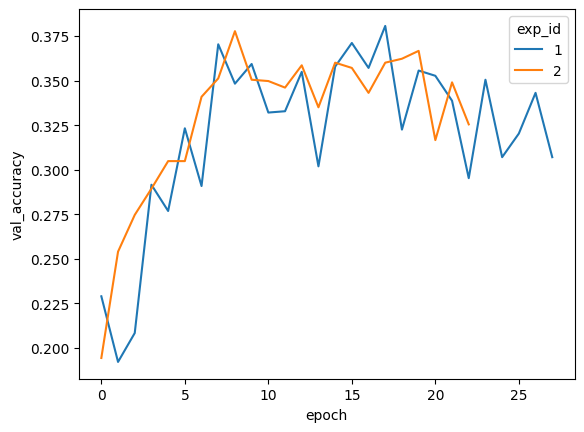

In [14]:
sns.lineplot(data=df_history, x="epoch", y="val_accuracy", hue="exp_id")

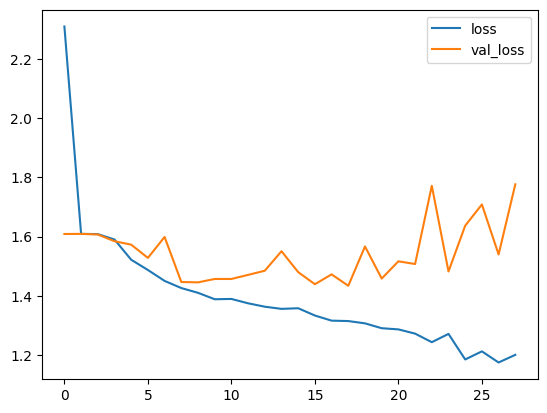

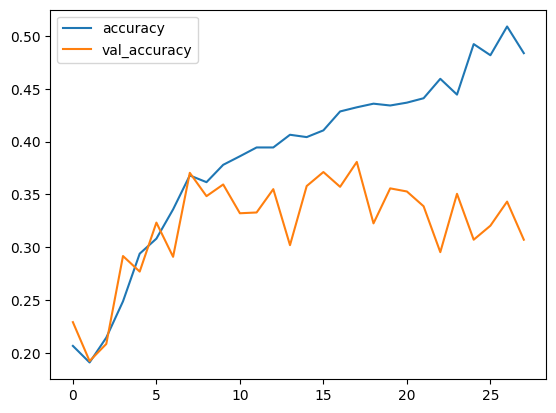

In [15]:
plot_experiment_results(df_history, "1")

Useful links found so far:
    
https://keras.io/api/data_loading/image/

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

https://keras.io/api/applications/vgg/

https://keras.io/api/applications/mobilenet/#mobilenetv2-function

https://keras.io/api/models/model_training_apis/

https://stackoverflow.com/questions/66715975/class-weights-in-cnn

https://www.kaggle.com/code/ryanholbrook/overfitting-and-underfitting